In [1]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as f
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from pyspark.ml.feature import Tokenizer
from pyspark.ml.feature import CountVectorizer

In [2]:
spark = SparkSession.builder \
    .master('local[*]')\
    .appName("NLP")\
    .getOrCreate()

23/06/21 17:19:16 WARN Utils: Your hostname, enricolm-virtual-machine resolves to a loopback address: 127.0.1.1; using 192.168.233.129 instead (on interface ens33)
23/06/21 17:19:16 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/06/21 17:19:17 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
dados = spark.read.csv("/home/enricolm/Documents/SparkNLP/imdb-reviews-pt-br.csv",
    escape = '\"',
    inferSchema = True,
    header = True                       
)

In [4]:
dados.show(3)

+---+--------------------+--------------------+---------+
| id|             text_en|             text_pt|sentiment|
+---+--------------------+--------------------+---------+
|  1|Once again Mr. Co...|Mais uma vez, o S...|      neg|
|  2|This is an exampl...|Este é um exemplo...|      neg|
|  3|First of all I ha...|Primeiro de tudo ...|      neg|
+---+--------------------+--------------------+---------+
only showing top 3 rows



In [5]:
dados.printSchema()

root
 |-- id: integer (nullable = true)
 |-- text_en: string (nullable = true)
 |-- text_pt: string (nullable = true)
 |-- sentiment: string (nullable = true)



In [6]:
dados.groupBy('sentiment')\
    .count()\
    .show()

+---------+-----+
|sentiment|count|
+---------+-----+
|      pos|24694|
|      neg|24765|
+---------+-----+



In [7]:
dados = dados.withColumn('sentiment', f.when(f.col('sentiment') == "neg", "NEGATIVO").otherwise('POSITIVO'))

In [8]:
dados.filter(f.col('sentiment') == "POSITIVO")\
    .select('text_pt')\
    .show(5, truncate = False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [9]:
dados.filter(f.col('sentiment') == "NEGATIVO")\
    .select('text_pt')\
    .show(5,truncate = False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [10]:
#teste para criar uma nuvem de palavra
amostra = dados.select('text_pt').sample(fraction= 0.1)
tudo = [text['text_pt'] for text in amostra.collect()]
tudo

['A melhor coisa sobre "The Prey" é o slogan ... "Não é humano e tem um machado"! O filme em si é um stinkaroo acolchoado ... intermináveis \u200b\u200bfotos de insetos e vida selvagem fazem o espectador querer morrer! Nenhum fã de slasher vai gostar desse lixo ..... Assista "Friday the 13th" novamente e grave qualquer cópia deste filme que você encontrar! Também é considerado um dos 25 piores filmes já feitos!',
 '1980 foi certamente um ano para maus filmes de terror. "Friday The 13th" e "The Burning" podem ter sido os melhores, mas sempre houve alguns fãs que não ficaram muito atrás, como "Dont Go Into The Woods Alone" e esse. Mas com toda a justiça "The Prey" está longe de ser tão ruim quanto "Não vá para o bosque", mas ainda não é grande. Uma coisa é que é apenas chato e agindo não é muito bom, mas muito melhor do que "DGITW" e este filme realmente tem algumas mulheres atraentes olhar para, todos os três clientes do sexo feminino foram impressionantes. Uma coisa, o que está acontec

In [11]:
nuvem = WordCloud(background_color='white',
                  width=1000,
                  height=600,
                  collocations=False,
                  prefer_horizontal=1).generate(str(tudo))


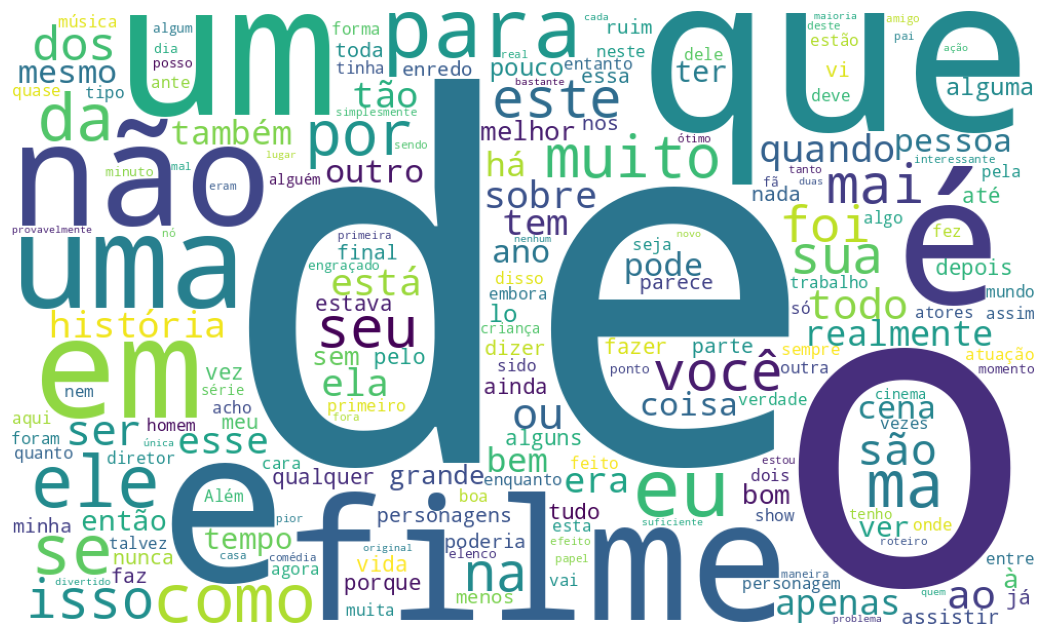

In [12]:
plt.figure(figsize=(20,8))
plt.imshow(nuvem)
plt.axis("off")
plt.show()

In [13]:
#removendo caracter especial

amostra = amostra.withColumn("texto_regex",f.regexp_replace("text_pt","[\$#,\"!%&'()*+-./;;<=>?@^_`´{|}~\\\\]",""))

In [14]:
amostra.show(truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [15]:
amostra = amostra.withColumn('texto_regex',f.trim(amostra.texto_regex))

In [16]:
amostra.show(truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [17]:
dados.printSchema()

root
 |-- id: integer (nullable = true)
 |-- text_en: string (nullable = true)
 |-- text_pt: string (nullable = true)
 |-- sentiment: string (nullable = false)



In [18]:
# colunasemid = [ coluna for coluna in dados.columns if coluna != 'id']
# dadosNull = dados.select([f.sum(f.col(coluna).isNull() | f.isnan(f.col(coluna))).alias(coluna) for coluna in colunasemid])
# dadosNull.show()

In [19]:
dados = dados.withColumn('texto_regex_pt',f.regexp_replace('text_pt',"[\$#,\"!%&'()*+-./;;<=>?@^_`´{|}~\\\\]",""))
dados = dados.withColumn('texto_regex_en',f.regexp_replace('text_en',"[\$#,\"!%&'()*+-./;;<=>?@^_`´{|}~\\\\]",""))

In [20]:
dados = dados.withColumn('texto_regex_pt', f.trim(dados['texto_regex_pt']))
dados = dados.withColumn('texto_regex_en', f.trim(dados['texto_regex_en']))

In [21]:
dados.show()

+---+--------------------+--------------------+---------+--------------------+--------------------+
| id|             text_en|             text_pt|sentiment|      texto_regex_pt|      texto_regex_en|
+---+--------------------+--------------------+---------+--------------------+--------------------+
|  1|Once again Mr. Co...|Mais uma vez, o S...| NEGATIVO|Mais uma vez o Sr...|Once again Mr Cos...|
|  2|This is an exampl...|Este é um exemplo...| NEGATIVO|Este é um exemplo...|This is an exampl...|
|  3|First of all I ha...|Primeiro de tudo ...| NEGATIVO|Primeiro de tudo ...|First of all I ha...|
|  4|Not even the Beat...|Nem mesmo os Beat...| NEGATIVO|Nem mesmo os Beat...|Not even the Beat...|
|  5|Brass pictures mo...|Filmes de fotos d...| NEGATIVO|Filmes de fotos d...|Brass pictures mo...|
|  6|A funny thing hap...|Uma coisa engraça...| NEGATIVO|Uma coisa engraça...|A funny thing hap...|
|  7|This German horro...|Este filme de ter...| NEGATIVO|Este filme de ter...|This German horro...|


In [22]:
tokenizer = Tokenizer(inputCol='texto_regex_pt' , outputCol='texto_tokenizado_pt')

dados_tokenizer = tokenizer.transform(dados)

In [23]:
dados_tokenizer.show()

+---+--------------------+--------------------+---------+--------------------+--------------------+--------------------+
| id|             text_en|             text_pt|sentiment|      texto_regex_pt|      texto_regex_en| texto_tokenizado_pt|
+---+--------------------+--------------------+---------+--------------------+--------------------+--------------------+
|  1|Once again Mr. Co...|Mais uma vez, o S...| NEGATIVO|Mais uma vez o Sr...|Once again Mr Cos...|[mais, uma, vez, ...|
|  2|This is an exampl...|Este é um exemplo...| NEGATIVO|Este é um exemplo...|This is an exampl...|[este, é, um, exe...|
|  3|First of all I ha...|Primeiro de tudo ...| NEGATIVO|Primeiro de tudo ...|First of all I ha...|[primeiro, de, tu...|
|  4|Not even the Beat...|Nem mesmo os Beat...| NEGATIVO|Nem mesmo os Beat...|Not even the Beat...|[nem, mesmo, os, ...|
|  5|Brass pictures mo...|Filmes de fotos d...| NEGATIVO|Filmes de fotos d...|Brass pictures mo...|[filmes, de, foto...|
|  6|A funny thing hap...|Uma co

In [24]:
from pyspark.sql.types import IntegerType
expre_lam = f.udf(lambda texto_tokenizado_pt : len(texto_tokenizado_pt), IntegerType())

dados_tokenizer = dados_tokenizer\
    .withColumn('Num_palavras', expre_lam(f.col('texto_tokenizado_pt')))

In [25]:
dados_tokenizer.show()

+---+--------------------+--------------------+---------+--------------------+--------------------+--------------------+------------+
| id|             text_en|             text_pt|sentiment|      texto_regex_pt|      texto_regex_en| texto_tokenizado_pt|Num_palavras|
+---+--------------------+--------------------+---------+--------------------+--------------------+--------------------+------------+
|  1|Once again Mr. Co...|Mais uma vez, o S...| NEGATIVO|Mais uma vez o Sr...|Once again Mr Cos...|[mais, uma, vez, ...|         168|
|  2|This is an exampl...|Este é um exemplo...| NEGATIVO|Este é um exemplo...|This is an exampl...|[este, é, um, exe...|         245|
|  3|First of all I ha...|Primeiro de tudo ...| NEGATIVO|Primeiro de tudo ...|First of all I ha...|[primeiro, de, tu...|         213|
|  4|Not even the Beat...|Nem mesmo os Beat...| NEGATIVO|Nem mesmo os Beat...|Not even the Beat...|[nem, mesmo, os, ...|         324|
|  5|Brass pictures mo...|Filmes de fotos d...| NEGATIVO|Filme

In [26]:
tokenizer = Tokenizer(inputCol= 'texto_regex_en', outputCol= 'texto_tokenizer_en')

dados_tokenizer = tokenizer.transform(dados_tokenizer)

dados_tokenizer.show()

+---+--------------------+--------------------+---------+--------------------+--------------------+--------------------+------------+--------------------+
| id|             text_en|             text_pt|sentiment|      texto_regex_pt|      texto_regex_en| texto_tokenizado_pt|Num_palavras|  texto_tokenizer_en|
+---+--------------------+--------------------+---------+--------------------+--------------------+--------------------+------------+--------------------+
|  1|Once again Mr. Co...|Mais uma vez, o S...| NEGATIVO|Mais uma vez o Sr...|Once again Mr Cos...|[mais, uma, vez, ...|         168|[once, again, mr,...|
|  2|This is an exampl...|Este é um exemplo...| NEGATIVO|Este é um exemplo...|This is an exampl...|[este, é, um, exe...|         245|[this, is, an, ex...|
|  3|First of all I ha...|Primeiro de tudo ...| NEGATIVO|Primeiro de tudo ...|First of all I ha...|[primeiro, de, tu...|         213|[first, of, all, ...|
|  4|Not even the Beat...|Nem mesmo os Beat...| NEGATIVO|Nem mesmo os 

In [27]:
expre_lam_en = f.udf(lambda texto_tokenizer_en : len(texto_tokenizer_en),IntegerType())

dados_tokenizer = dados_tokenizer\
    .withColumn('Word_Number', 
                expre_lam_en(f.col('texto_tokenizer_en')))

dados_tokenizer.show()

+---+--------------------+--------------------+---------+--------------------+--------------------+--------------------+------------+--------------------+-----------+
| id|             text_en|             text_pt|sentiment|      texto_regex_pt|      texto_regex_en| texto_tokenizado_pt|Num_palavras|  texto_tokenizer_en|Word_Number|
+---+--------------------+--------------------+---------+--------------------+--------------------+--------------------+------------+--------------------+-----------+
|  1|Once again Mr. Co...|Mais uma vez, o S...| NEGATIVO|Mais uma vez o Sr...|Once again Mr Cos...|[mais, uma, vez, ...|         168|[once, again, mr,...|        168|
|  2|This is an exampl...|Este é um exemplo...| NEGATIVO|Este é um exemplo...|This is an exampl...|[este, é, um, exe...|         245|[this, is, an, ex...|        232|
|  3|First of all I ha...|Primeiro de tudo ...| NEGATIVO|Primeiro de tudo ...|First of all I ha...|[primeiro, de, tu...|         213|[first, of, all, ...|        215

In [28]:
#Removendo as StopWords
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_pt = stopwords.words('portuguese')


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/enricolm/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [29]:
from pyspark.ml.feature import StopWordsRemover

stop_en = StopWordsRemover.loadDefaultStopWords('english')
stop_en

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 'her',
 'hers',
 'herself',
 'it',
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each',
 'few',
 'more',
 'most',
 'other',
 'some',
 'such',
 'no',
 'nor',
 '

In [30]:
remover = StopWordsRemover(inputCol='texto_tokenizado_pt', outputCol= 'texto_StopWords_pt', stopWords= stop_pt)

dados_stop = remover.transform(dados_tokenizer)

In [31]:
dados_stop.show()

+---+--------------------+--------------------+---------+--------------------+--------------------+--------------------+------------+--------------------+-----------+--------------------+
| id|             text_en|             text_pt|sentiment|      texto_regex_pt|      texto_regex_en| texto_tokenizado_pt|Num_palavras|  texto_tokenizer_en|Word_Number|  texto_StopWords_pt|
+---+--------------------+--------------------+---------+--------------------+--------------------+--------------------+------------+--------------------+-----------+--------------------+
|  1|Once again Mr. Co...|Mais uma vez, o S...| NEGATIVO|Mais uma vez o Sr...|Once again Mr Cos...|[mais, uma, vez, ...|         168|[once, again, mr,...|        168|[vez, sr, costner...|
|  2|This is an exampl...|Este é um exemplo...| NEGATIVO|Este é um exemplo...|This is an exampl...|[este, é, um, exe...|         245|[this, is, an, ex...|        232|[exemplo, motivo,...|
|  3|First of all I ha...|Primeiro de tudo ...| NEGATIVO|Pri

In [32]:
ex_lambda = f.udf(lambda texto_StopWords_pt : len(texto_StopWords_pt), IntegerType())

dados_stop = dados_stop\
    .withColumn('Palavras_validas', ex_lambda(f.col('texto_StopWords_pt')))


In [33]:
dados_stop.show()

+---+--------------------+--------------------+---------+--------------------+--------------------+--------------------+------------+--------------------+-----------+--------------------+----------------+
| id|             text_en|             text_pt|sentiment|      texto_regex_pt|      texto_regex_en| texto_tokenizado_pt|Num_palavras|  texto_tokenizer_en|Word_Number|  texto_StopWords_pt|Palavras_validas|
+---+--------------------+--------------------+---------+--------------------+--------------------+--------------------+------------+--------------------+-----------+--------------------+----------------+
|  1|Once again Mr. Co...|Mais uma vez, o S...| NEGATIVO|Mais uma vez o Sr...|Once again Mr Cos...|[mais, uma, vez, ...|         168|[once, again, mr,...|        168|[vez, sr, costner...|              79|
|  2|This is an exampl...|Este é um exemplo...| NEGATIVO|Este é um exemplo...|This is an exampl...|[este, é, um, exe...|         245|[this, is, an, ex...|        232|[exemplo, moti

In [34]:
remover = StopWordsRemover(inputCol='texto_tokenizer_en', outputCol= 'texto_StopWords_en', stopWords= stop_en)
dados_stop = remover.transform(dados_stop)

ex_lambda = f.udf(lambda texto_StopWords_en : len(texto_StopWords_en), IntegerType())

dados_stop = dados_stop\
    .withColumn('Valid_Words', ex_lambda(f.col('texto_StopWords_en')))


dados_stop.show()

+---+--------------------+--------------------+---------+--------------------+--------------------+--------------------+------------+--------------------+-----------+--------------------+----------------+--------------------+-----------+
| id|             text_en|             text_pt|sentiment|      texto_regex_pt|      texto_regex_en| texto_tokenizado_pt|Num_palavras|  texto_tokenizer_en|Word_Number|  texto_StopWords_pt|Palavras_validas|  texto_StopWords_en|Valid_Words|
+---+--------------------+--------------------+---------+--------------------+--------------------+--------------------+------------+--------------------+-----------+--------------------+----------------+--------------------+-----------+
|  1|Once again Mr. Co...|Mais uma vez, o S...| NEGATIVO|Mais uma vez o Sr...|Once again Mr Cos...|[mais, uma, vez, ...|         168|[once, again, mr,...|        168|[vez, sr, costner...|              79|[mr, costner, dra...|         73|
|  2|This is an exampl...|Este é um exemplo...| 

In [35]:
cv = CountVectorizer(inputCol='texto_StopWords_pt', outputCol='texto_Bag_pt')

In [36]:
model_cv = cv.fit(dados_stop)
dados_bag = model_cv.transform(dados_stop)

In [37]:
dados_bag.select('texto_StopWords_pt','texto_Bag_pt').show(truncate=False)

23/06/21 17:19:46 WARN DAGScheduler: Broadcasting large task binary with size 1934.3 KiB


+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [38]:
cv_en = CountVectorizer(inputCol='texto_StopWords_en', outputCol='texto_Bag_en')
model_cv_en = cv_en.fit(dados_bag)
dados_bag = model_cv_en.transform(dados_bag)

In [39]:
dados_bag.select('texto_StopWords_en','texto_Bag_en').show(truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

23/06/21 17:19:53 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB


In [40]:
dados_bag.show()

23/06/21 17:19:54 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB


+---+--------------------+--------------------+---------+--------------------+--------------------+--------------------+------------+--------------------+-----------+--------------------+----------------+--------------------+-----------+--------------------+--------------------+
| id|             text_en|             text_pt|sentiment|      texto_regex_pt|      texto_regex_en| texto_tokenizado_pt|Num_palavras|  texto_tokenizer_en|Word_Number|  texto_StopWords_pt|Palavras_validas|  texto_StopWords_en|Valid_Words|        texto_Bag_pt|        texto_Bag_en|
+---+--------------------+--------------------+---------+--------------------+--------------------+--------------------+------------+--------------------+-----------+--------------------+----------------+--------------------+-----------+--------------------+--------------------+
|  1|Once again Mr. Co...|Mais uma vez, o S...| NEGATIVO|Mais uma vez o Sr...|Once again Mr Cos...|[mais, uma, vez, ...|         168|[once, again, mr,...|      

In [41]:
from pyspark.ml.feature import HashingTF

tf = HashingTF(inputCol= 'texto_StopWords_pt', outputCol='texto_TF_pt', numFeatures= 100)
dados_tf = tf.transform(dados_stop)


In [42]:
dados_tf.select('texto_StopWords_pt','texto_TF_pt').show(5, truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [43]:
tf = HashingTF(inputCol= 'texto_StopWords_en', outputCol='texto_TF_en', numFeatures= 100)

dados_tf = tf.transform(dados_tf)

dados_tf.select('texto_StopWords_en', 'texto_TF_en').show(truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [44]:
dados_tf.show()

+---+--------------------+--------------------+---------+--------------------+--------------------+--------------------+------------+--------------------+-----------+--------------------+----------------+--------------------+-----------+--------------------+--------------------+
| id|             text_en|             text_pt|sentiment|      texto_regex_pt|      texto_regex_en| texto_tokenizado_pt|Num_palavras|  texto_tokenizer_en|Word_Number|  texto_StopWords_pt|Palavras_validas|  texto_StopWords_en|Valid_Words|         texto_TF_pt|         texto_TF_en|
+---+--------------------+--------------------+---------+--------------------+--------------------+--------------------+------------+--------------------+-----------+--------------------+----------------+--------------------+-----------+--------------------+--------------------+
|  1|Once again Mr. Co...|Mais uma vez, o S...| NEGATIVO|Mais uma vez o Sr...|Once again Mr Cos...|[mais, uma, vez, ...|         168|[once, again, mr,...|      

In [45]:
from pyspark.ml.feature import IDF
idf = IDF(inputCol='texto_TF_pt', outputCol='texto_IDF_pt')
modelo_idf = idf.fit(dados_tf)
dados_idf = modelo_idf.transform(dados_tf)
dados_idf.select('texto_TF_pt', 'texto_IDF_pt').show(truncate=False)

+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [46]:
idf = IDF(inputCol= 'texto_TF_en', outputCol='texto_IDF_en')
model_idf_en = idf.fit(dados_idf)
dados_idf = model_idf_en.transform(dados_idf)
dados_idf = dados_idf\
    .select('texto_TF_en','texto_IDF_en')\
    .limit(2)\
    .show(truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [47]:
#Usando Pipeline para treinar todos os modelos

dados = spark.read.csv('/home/enricolm/Documents/SparkNLP/imdb-reviews-pt-br.csv', escape="\'", inferSchema=True, header=True)

dados = dados.withColumn('sentiment', f.when(f.col('sentiment') == "neg", "NEGATIVO").otherwise('POSITIVO'))


from pyspark.ml.feature import StringIndexer

si = StringIndexer(inputCol='sentiment' , outputCol= 'label')

dados = si.fit(dados).transform(dados)
dados.show()


+---+--------------------+--------------------+---------+-----+
| id|             text_en|             text_pt|sentiment|label|
+---+--------------------+--------------------+---------+-----+
|  1|Once again Mr. Co...|Mais uma vez, o S...| NEGATIVO|  1.0|
|  2|This is an exampl...|Este é um exemplo...| NEGATIVO|  1.0|
|  3|First of all I ha...|"Primeiro de tudo...| POSITIVO|  0.0|
|  4|Not even the Beat...|Nem mesmo os Beat...| NEGATIVO|  1.0|
|  5|Brass pictures mo...|Filmes de fotos d...| NEGATIVO|  1.0|
|  6|"A funny thing ha...| the hero is a de...| POSITIVO|  0.0|
|  7|This German horro...|Este filme de ter...| NEGATIVO|  1.0|
|  8|"Being a long-tim...| plots and twists...| POSITIVO|  0.0|
|  9|"""Tokyo Eyes"" t...|                talk| POSITIVO|  0.0|
| 10|Wealthy horse ran...|Fazendeiros ricos...| NEGATIVO|  1.0|
| 11|"Cage plays a dru...|"Cage interpreta ...| NEGATIVO|  1.0|
| 12|First of all, I w...|Primeiro de tudo,...| NEGATIVO|  1.0|
| 13|So tell me - what...|Então me diga 

In [48]:
dados = dados.withColumn('texto_regex_pt',f.regexp_replace('text_pt',"[\$#,\"!%&'()*+-./;;<=>?@^_`´{|}~\\\\]",""))
dados = dados.withColumn('texto_regex_en',f.regexp_replace('text_en',"[\$#,\"!%&'()*+-./;;<=>?@^_`´{|}~\\\\]",""))

# %%
dados = dados.withColumn('texto_regex_pt', f.trim(dados['texto_regex_pt']))
dados = dados.withColumn('texto_regex_en', f.trim(dados['texto_regex_en']))
dados.show()

+---+--------------------+--------------------+---------+-----+--------------------+--------------------+
| id|             text_en|             text_pt|sentiment|label|      texto_regex_pt|      texto_regex_en|
+---+--------------------+--------------------+---------+-----+--------------------+--------------------+
|  1|Once again Mr. Co...|Mais uma vez, o S...| NEGATIVO|  1.0|Mais uma vez o Sr...|Once again Mr Cos...|
|  2|This is an exampl...|Este é um exemplo...| NEGATIVO|  1.0|Este é um exemplo...|This is an exampl...|
|  3|First of all I ha...|"Primeiro de tudo...| POSITIVO|  0.0|Primeiro de tudo ...|First of all I ha...|
|  4|Not even the Beat...|Nem mesmo os Beat...| NEGATIVO|  1.0|Nem mesmo os Beat...|Not even the Beat...|
|  5|Brass pictures mo...|Filmes de fotos d...| NEGATIVO|  1.0|Filmes de fotos d...|Brass pictures mo...|
|  6|"A funny thing ha...| the hero is a de...| POSITIVO|  0.0|the hero is a dea...|A funny thing hap...|
|  7|This German horro...|Este filme de ter...

In [49]:
dados.na.drop()
stop_pt = StopWordsRemover.loadDefaultStopWords('portuguese')

In [50]:
from pyspark.ml import Pipeline

tokenizer = Tokenizer(inputCol='texto_regex_pt' , outputCol='texto_tokenizado_pt')
tokenizer_en = Tokenizer(inputCol= 'texto_regex_en', outputCol= 'texto_tokenizer_en')
remover = StopWordsRemover(inputCol='texto_tokenizado_pt', outputCol= 'texto_StopWords_pt', stopWords= stop_pt)
remover_en = StopWordsRemover(inputCol='texto_tokenizer_en', outputCol= 'texto_StopWords_en', stopWords= stop_en)
tf = HashingTF(inputCol= remover.getOutputCol(), outputCol='texto_TF_pt', numFeatures= 1000)
tf_en = HashingTF(inputCol= remover_en.getOutputCol(), outputCol='texto_TF_en', numFeatures= 1000)
idf = IDF(inputCol='texto_TF_pt', outputCol='texto_IDF_pt')
idf_en = IDF(inputCol= 'texto_TF_en', outputCol='texto_IDF_en')


pipeline = Pipeline(stages=[tokenizer,tokenizer_en,remover,remover_en,tf,tf_en,idf,idf_en])

In [51]:
dados_pipe = pipeline.fit(dados).transform(dados)

23/06/21 17:20:10 ERROR Executor: Exception in task 2.0 in stage 44.0 (TID 81)
org.apache.spark.SparkException: [FAILED_EXECUTE_UDF] Failed to execute user defined function (Tokenizer$$Lambda$3765/0x0000000841539840: (string) => array<string>).
	at org.apache.spark.sql.errors.QueryExecutionErrors$.failedExecuteUserDefinedFunctionError(QueryExecutionErrors.scala:217)
	at org.apache.spark.sql.errors.QueryExecutionErrors.failedExecuteUserDefinedFunctionError(QueryExecutionErrors.scala)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:760)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.s

Py4JJavaError: An error occurred while calling o557.fit.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 2 in stage 44.0 failed 1 times, most recent failure: Lost task 2.0 in stage 44.0 (TID 81) (192.168.233.129 executor driver): org.apache.spark.SparkException: [FAILED_EXECUTE_UDF] Failed to execute user defined function (Tokenizer$$Lambda$3765/0x0000000841539840: (string) => array<string>).
	at org.apache.spark.sql.errors.QueryExecutionErrors$.failedExecuteUserDefinedFunctionError(QueryExecutionErrors.scala:217)
	at org.apache.spark.sql.errors.QueryExecutionErrors.failedExecuteUserDefinedFunctionError(QueryExecutionErrors.scala)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:760)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at scala.collection.AbstractIterator.foreach(Iterator.scala:1431)
	at scala.collection.TraversableOnce.foldLeft(TraversableOnce.scala:199)
	at scala.collection.TraversableOnce.foldLeft$(TraversableOnce.scala:192)
	at scala.collection.AbstractIterator.foldLeft(Iterator.scala:1431)
	at scala.collection.TraversableOnce.aggregate(TraversableOnce.scala:260)
	at scala.collection.TraversableOnce.aggregate$(TraversableOnce.scala:260)
	at scala.collection.AbstractIterator.aggregate(Iterator.scala:1431)
	at org.apache.spark.rdd.RDD.$anonfun$treeAggregate$4(RDD.scala:1234)
	at org.apache.spark.rdd.RDD.$anonfun$treeAggregate$6(RDD.scala:1235)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2(RDD.scala:853)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2$adapted(RDD.scala:853)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:92)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:161)
	at org.apache.spark.scheduler.Task.run(Task.scala:139)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:554)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1529)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:557)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	at java.base/java.lang.Thread.run(Thread.java:829)
Caused by: java.lang.NullPointerException
	at org.apache.spark.ml.feature.Tokenizer.$anonfun$createTransformFunc$1(Tokenizer.scala:40)
	... 31 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2785)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2721)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2720)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2720)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1206)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1206)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1206)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2984)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2923)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2912)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:971)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2263)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2358)
	at org.apache.spark.rdd.RDD.$anonfun$fold$1(RDD.scala:1172)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:405)
	at org.apache.spark.rdd.RDD.fold(RDD.scala:1166)
	at org.apache.spark.rdd.RDD.$anonfun$treeAggregate$2(RDD.scala:1259)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:405)
	at org.apache.spark.rdd.RDD.treeAggregate(RDD.scala:1226)
	at org.apache.spark.rdd.RDD.$anonfun$treeAggregate$1(RDD.scala:1212)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:405)
	at org.apache.spark.rdd.RDD.treeAggregate(RDD.scala:1212)
	at org.apache.spark.mllib.feature.IDF.fit(IDF.scala:55)
	at org.apache.spark.ml.feature.IDF.fit(IDF.scala:93)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:829)
Caused by: org.apache.spark.SparkException: [FAILED_EXECUTE_UDF] Failed to execute user defined function (Tokenizer$$Lambda$3765/0x0000000841539840: (string) => array<string>).
	at org.apache.spark.sql.errors.QueryExecutionErrors$.failedExecuteUserDefinedFunctionError(QueryExecutionErrors.scala:217)
	at org.apache.spark.sql.errors.QueryExecutionErrors.failedExecuteUserDefinedFunctionError(QueryExecutionErrors.scala)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:760)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at scala.collection.AbstractIterator.foreach(Iterator.scala:1431)
	at scala.collection.TraversableOnce.foldLeft(TraversableOnce.scala:199)
	at scala.collection.TraversableOnce.foldLeft$(TraversableOnce.scala:192)
	at scala.collection.AbstractIterator.foldLeft(Iterator.scala:1431)
	at scala.collection.TraversableOnce.aggregate(TraversableOnce.scala:260)
	at scala.collection.TraversableOnce.aggregate$(TraversableOnce.scala:260)
	at scala.collection.AbstractIterator.aggregate(Iterator.scala:1431)
	at org.apache.spark.rdd.RDD.$anonfun$treeAggregate$4(RDD.scala:1234)
	at org.apache.spark.rdd.RDD.$anonfun$treeAggregate$6(RDD.scala:1235)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2(RDD.scala:853)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2$adapted(RDD.scala:853)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:92)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:161)
	at org.apache.spark.scheduler.Task.run(Task.scala:139)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:554)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1529)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:557)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	... 1 more
Caused by: java.lang.NullPointerException
	at org.apache.spark.ml.feature.Tokenizer.$anonfun$createTransformFunc$1(Tokenizer.scala:40)
	... 31 more


In [ ]:
dados_pipe.show(truncate=False)

+---+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
idf = IDF(inputCol='texto_TF_pt', outputCol='texto_IDF_pt')
modelo_idf = idf.fit(dados_pipe)
dados_pipe = modelo_idf.transform(dados_pipe)
dados_pipe.select('texto_TF_pt', 'texto_IDF_pt').show(truncate=False)

# %%
idf = IDF(inputCol= 'texto_TF_en', outputCol='texto_IDF_en')
model_idf_en = idf.fit(dados_pipe)
dados_pipe = model_idf_en.transform(dados_pipe)
dados_pipe = dados_pipe\
    .select('texto_TF_en','texto_IDF_en')\
    .limit(2)\
    .show(truncate=False)